In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(tidymodels)
library(survival)
library(cowplot)
library(future)
library(censored)
})
theme_set(theme_cowplot())
options(repr.plot.width = 15, repr.plot.height = 9)
set.seed(42)

In [2]:
# the multi model fitting process will use multiple cores
plan(multicore, workers = 6)

# Comparing survival prediction models with tidymodels

When it comes to predicting survival, we can't just do a simple regression because the dataset often includes censored data points,

the most common model used in these cases is the Cox proportional hazards model,

there are other options, but when considering them it is always good to check if they out-perform the cox model on your data.

if you are not familiar with survival analysis, it's better to start here: http://www.sthda.com/english/wiki/survival-analysis-basics

# Dataset preprocessing
To illustrate we will use a dataset from the survival package, check `?survival::pbc` for more info

In [3]:
head(pbc)

,id,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
,<int>,<int>,<int>,<int>,<dbl>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
1,1,400,2,1,58.7652292950034,f,1,1,1,1.0,14.5,261,2.60,156,1718.0,137.95,172,190,12.2,4
2,2,4500,0,1,56.4462696783025,f,0,1,1,0.0,1.1,302,4.14,54,7394.8,113.52,88,221,10.6,3
3,3,1012,2,1,70.0725530458590,m,0,0,0,0.5,1.4,176,3.48,210,516.0,96.10,55,151,12.0,4
4,4,1925,2,1,54.7405886379192,f,0,1,1,0.5,1.8,244,2.54,64,6121.8,60.63,92,183,10.3,4
5,5,1504,1,2,38.1054072553046,f,0,1,1,0.0,3.4,279,3.53,143,671.0,113.15,72,136,10.9,3
6,6,2503,2,2,66.2587268993840,f,0,1,0,0.0,0.8,248,3.98,50,944.0,93.00,63,NA,11.0,3


In [4]:
data <- 
    # remove rows with missing data
    na.omit(pbc) |> 
    # the surv variable will be our outcome
    mutate(surv=Surv(time, status==2)) 
dim(data)

[1] 276  21

In [5]:
# separate 20% of the dataset for testing the models later
data_split <- initial_split(data, prop = 0.8, strata=time)

In [6]:
# create a recipe, to prepare the data for fitting
rec <- recipe(surv ~ ., data=data) |>
    # remove uneeded variables
    step_rm(time, status, id) |> 
    # remove variables with zero variance
    step_zv(all_predictors()) |> 
    # transform factors into integers
    step_integer(all_nominal_predictors()) 

# Model definitions
These are the models we will be testing, they are provided by the [censored](https://censored.tidymodels.org) package.

note that some models, such as random forest, have hyper-parameters,

these parameters are tunable, we will tune some of them to illustrate.

In [7]:
models <- list(
    cox_ph_survival = proportional_hazards(engine='survival'),
    cox_ph_glmnet = proportional_hazards(penalty=tune(), mixture=tune(), engine='glmnet'),
    survreg_flexsurv = survival_reg(engine='flexsurv'),
    rand_forest_partykit = rand_forest(trees = tune(), engine='partykit'),
    rand_forest_aorsf = rand_forest(trees = tune(), engine='aorsf'),
    decision_tree_partykit = decision_tree(engine='partykit'),
    boost_tree_mboost = boost_tree(trees = tune(), engine='mboost')
) |>
map(~set_mode(.x,'censored regression'))

In [8]:
wsets <- workflow_set(
    preproc=list(rec),
    models=models
)

# Model fitting

Now, we fit all the models with our training data, 

to evaluate which model is best, we will use cross-validation resampling, so each model will be fitted multiple times

if there are tunable parameters, multiple fits will be done for each candidate parameter set, 

the number of candidates tested is controlled by the grid argument below.

In [9]:
# 5-fold cross-validation resampling for the tunning and comparisons
folds <- vfold_cv(training(data_split), v=5, strata=time)

In [10]:
res <- workflow_map(
    wsets,
    "tune_grid",
    seed = 42,
    grid = 10,
    resamples = folds,
    # this metric will be calculated for each fit
    metrics=metric_set(concordance_survival)
)

# Metrics

During the fit, the [concordance index](https://yardstick.tidymodels.org/reference/concordance_survival.html) was calculated for each combination,

now we can gather these results and build a table:

In [11]:
# collect metrics from the result object
m <- collect_metrics(res)
# remove a few unrelated columns
mb <- mutate(m,
    label = gsub('recipe_', '', wflow_id),
    preproc=NULL,
    .estimator=NULL,
    n=NULL,
    .metric=NULL
) |>
# select the best parameter set for each model, according to the metric
slice_max(mean, by=label, n=1, with_ties=FALSE)
mb

wflow_id,.config,model,mean,std_err,label
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
recipe_cox_ph_survival,Preprocessor1_Model1,proportional_hazards,0.809202426920204,0.0246510956539134,cox_ph_survival
recipe_cox_ph_glmnet,Preprocessor1_Model02,proportional_hazards,0.827374478729870,0.0260384841178290,cox_ph_glmnet
recipe_survreg_flexsurv,Preprocessor1_Model1,survival_reg,0.812798987394412,0.0254010738957239,survreg_flexsurv
recipe_rand_forest_partykit,Preprocessor1_Model03,rand_forest,0.832411219728944,0.0195804127464225,rand_forest_partykit
recipe_rand_forest_aorsf,Preprocessor1_Model08,rand_forest,0.848819770177259,0.0249418414304294,rand_forest_aorsf
recipe_decision_tree_partykit,Preprocessor1_Model1,decision_tree,0.725301941041225,0.0341123982952786,decision_tree_partykit
recipe_boost_tree_mboost,Preprocessor1_Model08,boost_tree,0.820025751587363,0.0252241065143019,boost_tree_mboost


Note that since we are using cross-validation, each model was fitted multiple times, so we have a mean and std_err.

we can also fit these models with the 20% test data we separated earlier:

In [12]:
final_fits <- 
    # map across each model in the table above
    set_names(mb$wflow_id) |>
    map(function(wi) {
        # select the best model config, in case of tunnable parameters
        bwr <- extract_workflow_set_result(res, wi)
        best_params <- select_best(bwr, metric='concordance_survival')
        bw <- finalize_workflow(
            extract_workflow(res, wi), 
            best_params
        )
    
        # re-fit the best config with the initial 80% train / 20% test
        last_fit(
            bw,
            split = data_split,
            metrics = metric_set(concordance_survival)
        )
    })

In [13]:
test_m <-
    # collect the metrics of the final model
    map(final_fits, collect_metrics) |>
    bind_rows(.id='wflow_id') |>
    select(wflow_id, test_metric=.estimate)

test_m

wflow_id,test_metric
<chr>,<dbl>
recipe_cox_ph_survival,0.870346598202824
recipe_cox_ph_glmnet,0.884467265725289
recipe_survreg_flexsurv,0.871630295250321
recipe_rand_forest_partykit,0.889602053915276
recipe_rand_forest_aorsf,0.889602053915276
recipe_decision_tree_partykit,0.819640564826701
recipe_boost_tree_mboost,0.875481386392811


To make it easier to visualize all these results, we can make a plot

the validation mean and std_err will be plotted in black as a point and error bar,

and for comparison, we added a cross to indicate the score of the fully fitted model on the test set.

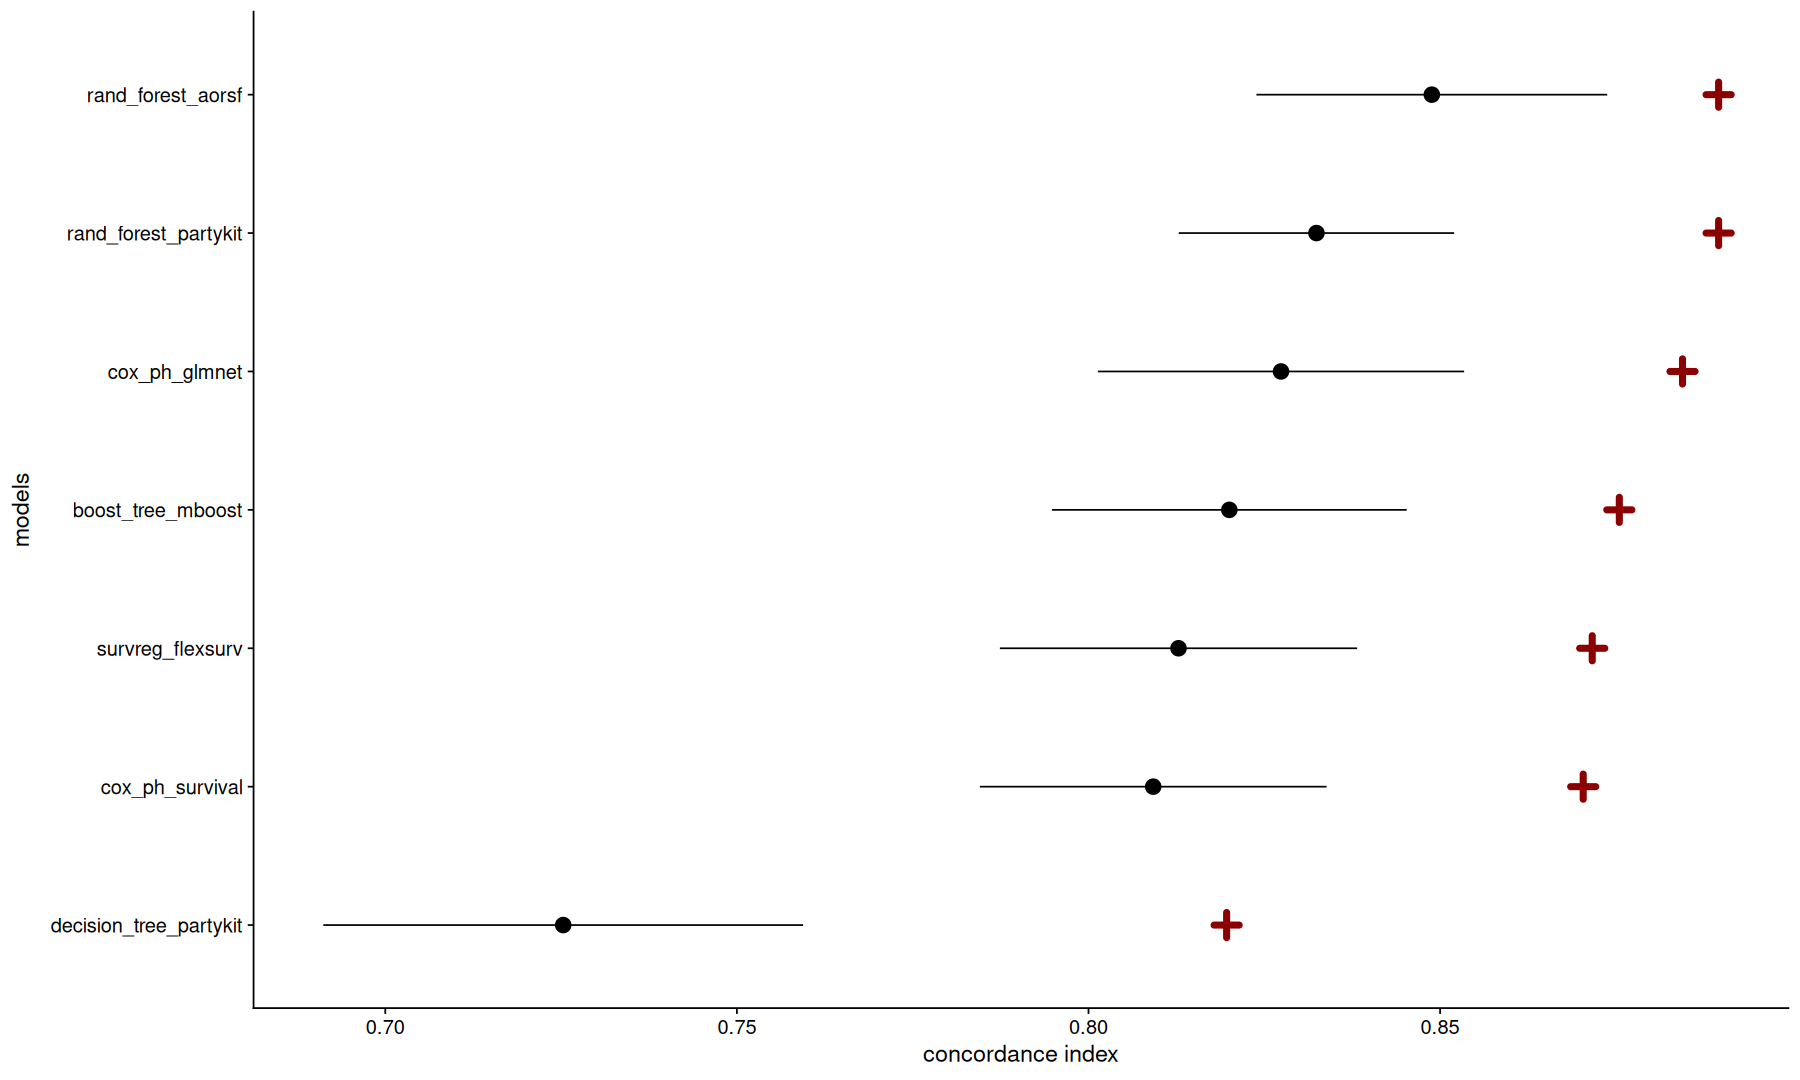

In [14]:
inner_join(mb, test_m, by='wflow_id') |>
ggplot(aes(y=fct_reorder(label,mean), x=mean)) +
geom_point(size=4) +
geom_point(aes(x=test_metric), shape=3, size=3, stroke=3, color='darkred') +
geom_pointrange(aes(xmin=mean-std_err, xmax=mean+std_err)) +
labs(x='concordance index', y='models')

Needless to say, you shouldn't assume the best model here will also be the best in other datasets,
always test on your data.

# Variable importance

Once we decide which model we want to use, we can extract the model object, and do further analyses,

such as ranking the dataset variables by how important the model scored them.

In [15]:
names(final_fits)

[1] "recipe_cox_ph_survival"        "recipe_cox_ph_glmnet"         
[3] "recipe_survreg_flexsurv"       "recipe_rand_forest_partykit"  
[5] "recipe_rand_forest_aorsf"      "recipe_decision_tree_partykit"
[7] "recipe_boost_tree_mboost"

In [16]:
aorsf_obj <-
    final_fits[['recipe_rand_forest_aorsf']] |>
    extract_fit_engine()
aorsf_obj

---------- Oblique random survival forest

     Linear combinations: Accelerated Cox regression
          N observations: 220
                N events: 89
                 N trees: 84
      N predictors total: 17
   N predictors per node: 5
 Average leaves per tree: 17.3928571428571
Min observations in leaf: 5
      Min events in leaf: 1
          OOB stat value: 0.83
           OOB stat type: Harrell's C-index
     Variable importance: anova

-----------------------------------------

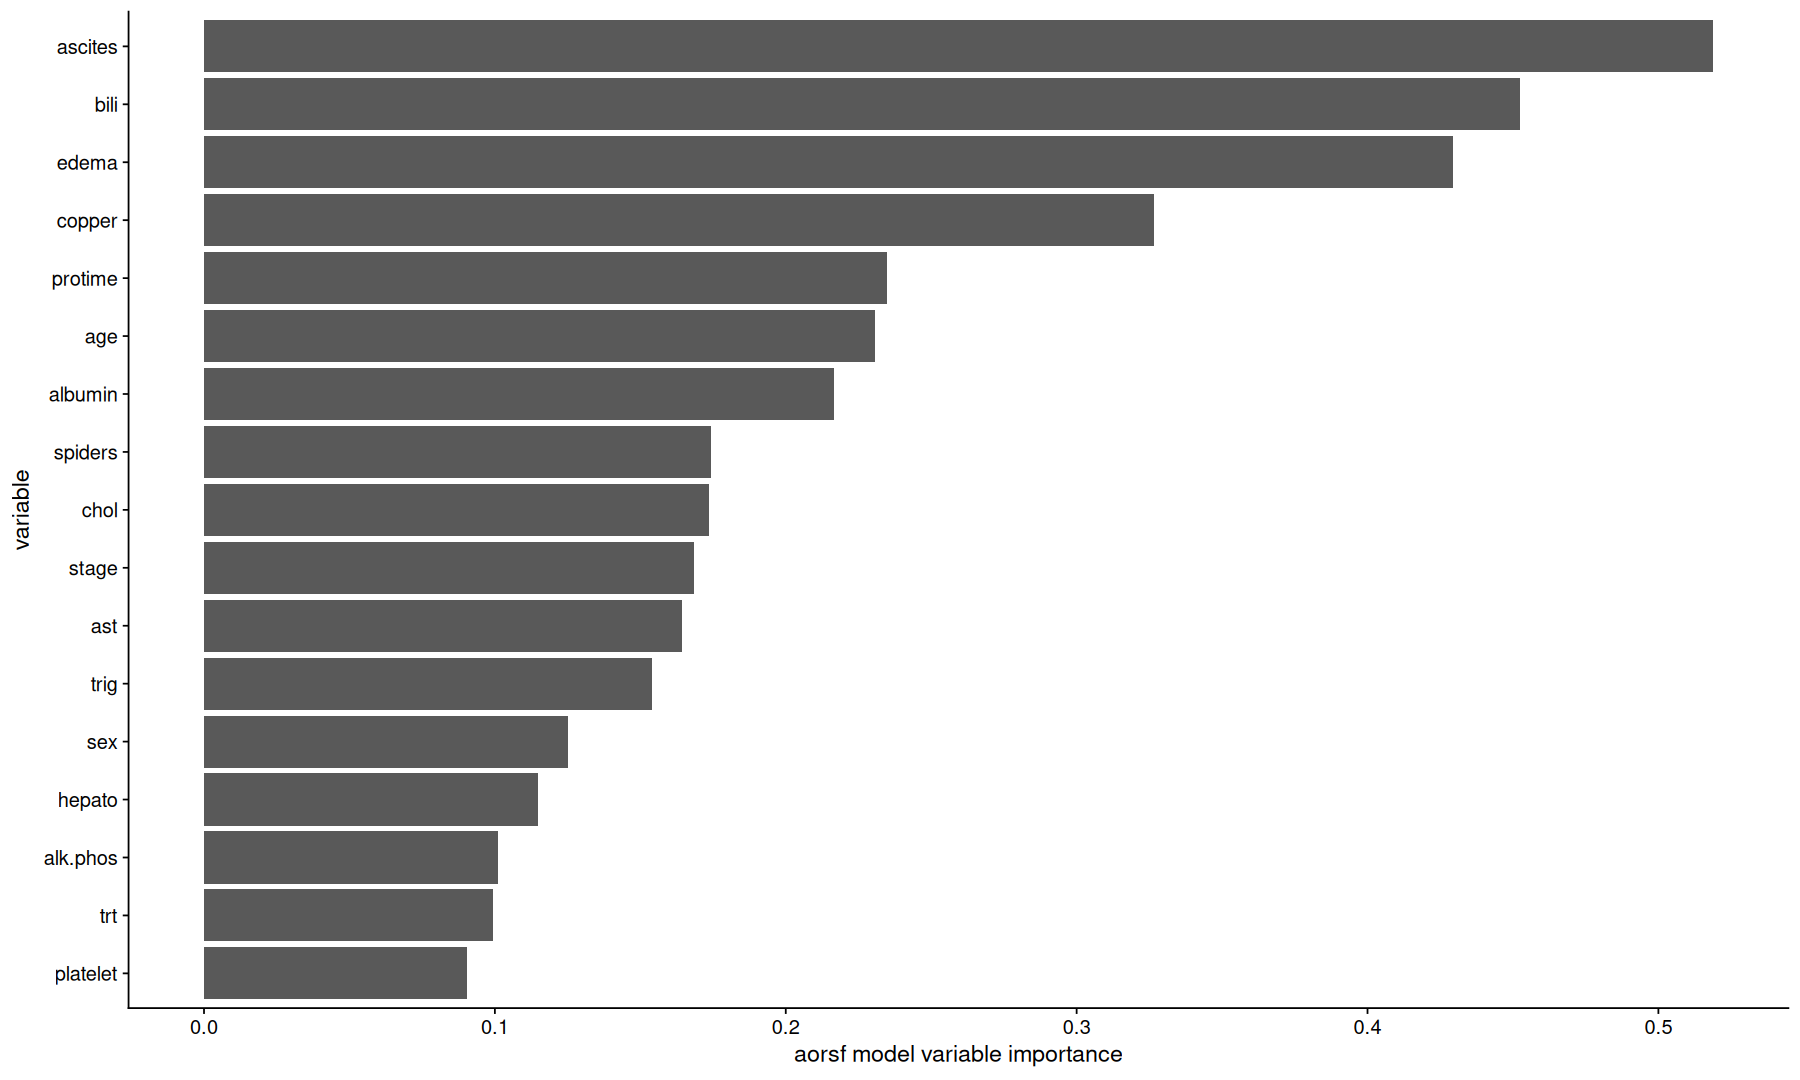

In [17]:
aorsf_obj$get_importance_clean() |>
enframe() |>
ggplot(aes(y=fct_reorder(name, value), x=value)) +
geom_col() +
labs(x='aorsf model variable importance', y='variable')